# LUNA - Malignancy Prediction



## Install Libraries

In [1]:
!pip install diskcache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.5 MB/s eta 0:00:00


# Utils

In [2]:
import collections
import copy
import datetime
import gc
import time
import sys
import math

import numpy as np

In [3]:
IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

In [4]:
def importstr(module_str, from_=None):
    """
    >>> importstr('os')
    <module 'os' from '.../os.pyc'>
    >>> importstr('math', 'fabs')
    <built-in function fabs>
    """
    if from_ is None and ':' in module_str:
        module_str, from_ = module_str.rsplit(':')

    module = __import__(module_str)
    for sub_str in module_str.split('.')[1:]:
        module = getattr(module, sub_str)

    if from_:
        try:
            return getattr(module, from_)
        except:
            raise ImportError('{}.{}'.format(module_str, from_))
    return module

In [5]:
import logging
import logging.handlers

root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

# Some libraries attempt to add their own root logger handlers. This is
# annoying and so we get rid of them.
for handler in list(root_logger.handlers):
    root_logger.removeHandler(handler)

logfmt_str = "%(asctime)s %(levelname)-8s pid:%(process)d %(name)s:%(lineno)03d:%(funcName)s %(message)s"
formatter = logging.Formatter(logfmt_str)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(formatter)
streamHandler.setLevel(logging.DEBUG)

root_logger.addHandler(streamHandler)

In [6]:
log = logging.getLogger('nb')
log.setLevel(logging.DEBUG)

In [7]:
def enumerateWithEstimate(
        iter,
        desc_str,
        start_ndx=0,
        print_ndx=4,
        backoff=None,
        iter_len=None,
):
    """
    In terms of behavior, `enumerateWithEstimate` is almost identical
    to the standard `enumerate` (the differences are things like how
    our function returns a generator, while `enumerate` returns a
    specialized `<enumerate object at 0x...>`).

    However, the side effects (logging, specifically) are what make the
    function interesting.

    :param iter: `iter` is the iterable that will be passed into
        `enumerate`. Required.

    :param desc_str: This is a human-readable string that describes
        what the loop is doing. The value is arbitrary, but should be
        kept reasonably short. Things like `"epoch 4 training"` or
        `"deleting temp files"` or similar would all make sense.

    :param start_ndx: This parameter defines how many iterations of the
        loop should be skipped before timing actually starts. Skipping
        a few iterations can be useful if there are startup costs like
        caching that are only paid early on, resulting in a skewed
        average when those early iterations dominate the average time
        per iteration.

        NOTE: Using `start_ndx` to skip some iterations makes the time
        spent performing those iterations not be included in the
        displayed duration. Please account for this if you use the
        displayed duration for anything formal.

        This parameter defaults to `0`.

    :param print_ndx: determines which loop interation that the timing
        logging will start on. The intent is that we don't start
        logging until we've given the loop a few iterations to let the
        average time-per-iteration a chance to stablize a bit. We
        require that `print_ndx` not be less than `start_ndx` times
        `backoff`, since `start_ndx` greater than `0` implies that the
        early N iterations are unstable from a timing perspective.

        `print_ndx` defaults to `4`.

    :param backoff: This is used to how many iterations to skip before
        logging again. Frequent logging is less interesting later on,
        so by default we double the gap between logging messages each
        time after the first.

        `backoff` defaults to `2` unless iter_len is > 1000, in which
        case it defaults to `4`.

    :param iter_len: Since we need to know the number of items to
        estimate when the loop will finish, that can be provided by
        passing in a value for `iter_len`. If a value isn't provided,
        then it will be set by using the value of `len(iter)`.

    :return:
    """
    if iter_len is None:
        iter_len = len(iter)

    if backoff is None:
        backoff = 2
        while backoff ** 7 < iter_len:
            backoff *= 2

    assert backoff >= 2
    while print_ndx < start_ndx * backoff:
        print_ndx *= backoff

    log.warning("{} ----/{}, starting".format(
        desc_str,
        iter_len,
    ))
    start_ts = time.time()
    for (current_ndx, item) in enumerate(iter):
        yield (current_ndx, item)
        if current_ndx == print_ndx:
            # ... <1>
            duration_sec = ((time.time() - start_ts)
                            / (current_ndx - start_ndx + 1)
                            * (iter_len-start_ndx)
                            )

            done_dt = datetime.datetime.fromtimestamp(start_ts + duration_sec)
            done_td = datetime.timedelta(seconds=duration_sec)

            log.info("{} {:-4}/{}, done at {}, {}".format(
                desc_str,
                current_ndx,
                iter_len,
                str(done_dt).rsplit('.', 1)[0],
                str(done_td).rsplit('.', 1)[0],
            ))

            print_ndx *= backoff

        if current_ndx + 1 == start_ndx:
            start_ts = time.time()

    log.warning("{} ----/{}, done at {}".format(
        desc_str,
        iter_len,
        str(datetime.datetime.now()).rsplit('.', 1)[0],
    ))

# Disk

In [8]:
import gzip

from diskcache import FanoutCache, Disk
from diskcache.core import MODE_BINARY # delete BytesType and BytesIO declarations

BytesType = bytes # Import them by ourselves
import io
BytesIO = io.BytesIO

log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

In [9]:
class GzipDisk(Disk):
    def store(self, value, read, key=None):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param value: value to convert
        :param bool read: True when value is file-like object
        :return: (size, mode, filename, value) tuple for Cache table
        """
        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesType:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param int mode: value mode raw, binary, text, or pickle
        :param str filename: filename of corresponding value
        :param value: database value
        :param bool read: when True, return an open file handle
        :return: corresponding Python value
        """
        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value

def getCache(scope_str):
    return FanoutCache('cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       # disk_min_file_size=2**20,
                       )

# Visialize

In [10]:
import matplotlib
matplotlib.use('nbagg')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
clim=(-1000.0, 300)

def findPositiveSamples(start_ndx=0, limit=100):
    ds = LunaDataset(sortby_str='label_and_size')

    positiveSample_list = []
    for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
            print(len(positiveSample_list), sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list

def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0

    ct = Ct(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc.index)), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc.index)], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc.row)), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc.row)], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc.col)), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc.col)], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc.index)), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc.row)), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc.col)), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)

# Datasets

### Import Libraries

In [12]:
import copy
import csv
import functools
import glob
import os
import random

from collections import namedtuple

import SimpleITK as sitk
import numpy as np

import torch
import torch.cuda
import torch.nn.functional as F
from torch.utils.data import Dataset

raw_cache = getCache('mal_raw')

# log = logging.getLogger(__name__)
# # log.setLevel(logging.WARN)
# # log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

In [13]:
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, hasAnnotation_bool, isMal_bool, diameter_mm, series_uid, center_xyz',
)
MaskTuple = namedtuple(
    'MaskTuple',
    'raw_dense_mask, dense_mask, body_mask, air_mask, raw_candidate_mask, candidate_mask, lung_mask, neg_mask, pos_mask',
)

In [14]:
LIST_LIMIT = 300000
@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    mhd_list = glob.glob('/kaggle/input/luna16/subset[0-5]/subset*/*.mhd')
    presentOnDisk_set= {os.path.split(p)[-1][:-4] for p in mhd_list}
    
    candidateInfo_list = []
    with open('/kaggle/input/annotations/annotations_with_malignancy.csv', "r") as f:
        for row in list(csv.reader(f))[1:]: # skip title row
            series_uid = row[0]
            
            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue
            
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])
            isMal_bool = {'False': False, 'True': True}[row[5]]
            
            candidateInfo_list.append(
                CandidateInfoTuple(
                    True,
                    True,
                    isMal_bool,
                    annotationDiameter_mm,
                    series_uid,
                    annotationCenter_xyz,
                )
            )
    
#     print(len(candidateInfo_list))
    
    with open('/kaggle/input/luna16/candidates.csv', 'r') as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            
            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue
            
            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])
            
            if not isNodule_bool:
                candidateInfo_list.append(
                    CandidateInfoTuple(
                        False,
                        False,
                        False,
                        0.0,
                        series_uid,
                        candidateCenter_xyz,
                    )
                )
            
            if len(candidateInfo_list) >= LIST_LIMIT:
                break
    
#     print(len(candidateInfo_list))
    
    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

In [17]:
@functools.lru_cache(1)
def getCandidateInfoDict(requireOnDisk_bool=True):
    candidateInfo_list = getCandidateInfoList(requireOnDisk_bool)
    candidateInfo_dict = {}

    for candidateInfo_tup in candidateInfo_list:
        candidateInfo_dict.setdefault(candidateInfo_tup.series_uid, []).append(candidateInfo_tup)

    return candidateInfo_dict

In [18]:
def getCtAugmentedCandidate(augmentation_dict, series_uid, center_xyz, width_irc, use_cache=True):
    if use_cache:
        ct_chunk, center_irc = getCtRawCandidate(series_uid, center_xyz, width_irc)
    else:
        ct = getCt(series_uid)
        ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)

    ct_t = torch.tensor(ct_chunk).unsqueeze(0).unsqueeze(0).to(torch.float32)

    transform_t = torch.eye(4)

    for i in range(3):
        if 'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1

        if 'offset' in augmentation_dict:
            offset_float = augmentation_dict['offset']
            random_float = (random.random() * 2 - 1)
            transform_t[i,3] = offset_float * random_float

        if 'scale' in augmentation_dict:
            scale_float = augmentation_dict['scale']
            random_float = (random.random() * 2 - 1)
            transform_t[i,i] *= 1.0 + scale_float * random_float


    if 'rotate' in augmentation_dict:
        angle_rad = random.random() * math.pi * 2
        s = math.sin(angle_rad)
        c = math.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

        transform_t @= rotation_t

    affine_t = F.affine_grid(
            transform_t[:3].unsqueeze(0).to(torch.float32),
            ct_t.size(),
            align_corners=False,
        )

    augmented_chunk = F.grid_sample(
            ct_t,
            affine_t,
            padding_mode='border',
            align_corners=False,
        ).to('cpu')

    if 'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t

    return augmented_chunk[0], center_irc

In [19]:
class Ct:
    def __init__(self, series_uid, buildMasks_bool=False):
        mhd_path = glob.glob('/kaggle/input/luna16/subset[0-5]/subset*/{}.mhd'.format(series_uid))[0]
        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
        
        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        
        self.series_uid = series_uid
        self.hu_a = ct_a
        
        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)
        
        candidateInfo_list = getCandidateInfoDict()[self.series_uid]
        
        self.positiveInfo_list = [
            candidate_tup for candidate_tup in candidateInfo_list if candidate_tup.isNodule_bool
        ]
        
        self.positive_Mask = self.buildAnnotationMask(self.positiveInfo_list)
        self.positive_indexes = (self.positive_Mask.sum(axis=(1,2)).nonzero()[0].tolist())
        
        self.buildMasks_bool = buildMasks_bool
        
        
    def buildAnnotationMask(self, positiveInfo_list, threshold_hu = -700):
        boundingBox_a = np.zeros_like(self.hu_a, dtype=np.bool_)
        
        for candidateInfo_tup in positiveInfo_list:
            center_irc = xyz2irc(candidateInfo_tup.center_xyz,
                                 self.origin_xyz,
                                 self.vxSize_xyz,
                                 self.direction_a)
            ci = int(center_irc.index)
            cr = int(center_irc.row)
            cc = int(center_irc.col)
            
            index_radius = 2
            try:
                while self.hu_a[ci+index_radius, cr, cc] > threshold_hu and \
                        self.hu_a[ci-index_radius, cr, cc] > threshold_hu:
                    index_radius += 1
            except IndexError:
                index_radius -= 1
                
            row_radius = 2
            try:
                while self.hu_a[ci, cr + row_radius, cc] > threshold_hu and \
                        self.hu_a[ci, cr - row_radius, cc] > threshold_hu:
                    row_radius += 1
            except IndexError:
                row_radius -= 1
                
            col_radius = 2
            try:
                while self.hu_a[ci, cr, cc + col_radius] > threshold_hu and \
                        self.hu_a[ci, cr, cc - col_radius] > threshold_hu:
                    col_radius += 1
            except IndexError:
                col_radius -= 1
                
            boundingBox_a[
                ci - index_radius:ci + index_radius + 1,
                cr - row_radius:cr + row_radius + 1,
                cc - col_radius:cc + col_radius + 1] = True
            
        mask_a = boundingBox_a & (self.hu_a > threshold_hu)
        
        return mask_a
        
        
    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz, 
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )
        
        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])
            
            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])
            
            if start_ndx < 0:
                start_ndx = 0
                end_ndx = int(width_irc[axis])
            
            if end_ndx > self.hu_a.shape[axis]:
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])
            
            slice_list.append(slice(start_ndx, end_ndx))
            
        ct_chunk = self.hu_a[tuple(slice_list)]
        
        if self.buildMasks_bool:
            pos_chunk = self.positive_Mask[tuple(slice_list)]
            return ct_chunk, pos_chunk, center_irc
        else:
            return ct_chunk, center_irc

In [20]:
@functools.lru_cache(1, typed=True)
def getCt(series_uid, buildMasks_bool=False):
    return Ct(series_uid, buildMasks_bool=buildMasks_bool)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

@raw_cache.memoize(typed=True)
def getCtSampleSize(series_uid):
    ct = Ct(series_uid, buildMasks_bool=True)
    return int(ct.hu_a.shape[0]), ct.positive_indexes


In [21]:
def getCtAugmentedCandidate(
        augmentation_dict,
        series_uid, center_xyz, width_irc,
        use_cache=True):
    if use_cache:
        ct_chunk, center_irc = getCtRawCandidate(series_uid, center_xyz, width_irc)
    else:
        ct = getCt(series_uid)
        ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)

    ct_t = torch.tensor(ct_chunk).unsqueeze(0).unsqueeze(0).to(torch.float32)

    transform_t = torch.eye(4)
    # ... <1>

    for i in range(3):
        if 'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1

        if 'offset' in augmentation_dict:
            offset_float = augmentation_dict['offset']
            random_float = (random.random() * 2 - 1)
            transform_t[i, 3] = offset_float * random_float

        if 'scale' in augmentation_dict:
            scale_float = augmentation_dict['scale']
            random_float = (random.random() * 2 - 1)
            transform_t[i,i] *= 1.0 + scale_float * random_float


    if 'rotate' in augmentation_dict:
        angle_rad = random.random() * math.pi * 2
        s = math.sin(angle_rad)
        c = math.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

        transform_t @= rotation_t

    affine_t = F.affine_grid(
            transform_t[:3].unsqueeze(0).to(torch.float32),
            ct_t.size(),
            align_corners=False,
        )

    augmented_chunk = F.grid_sample(
            ct_t,
            affine_t,
            padding_mode='border',
            align_corners=False,
        ).to('cpu')

    if 'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t

    return augmented_chunk[0], center_irc

### Create Dataset

In [22]:
class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
                 sortby_str='random',
                 ratio_int=0,
                 augmentation_dict=None,
                 candidateInfo_list=None,
            ):
        self.ratio_int = ratio_int
        self.augmentation_dict = augmentation_dict

        if candidateInfo_list:
            self.candidateInfo_list = copy.copy(candidateInfo_list)
            self.use_cache = False
        else:
            self.candidateInfo_list = copy.copy(getCandidateInfoList())
            self.use_cache = True

        if series_uid:
            self.series_list = [series_uid]
        else:
            self.series_list = sorted(set(candidateInfo_tup.series_uid for candidateInfo_tup in self.candidateInfo_list))

        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.series_list = self.series_list[::val_stride]
            assert self.series_list
        elif val_stride > 0:
            del self.series_list[::val_stride]
            assert self.series_list

        series_set = set(self.series_list)
        self.candidateInfo_list = [x for x in self.candidateInfo_list if x.series_uid in series_set]

        if sortby_str == 'random':
            random.shuffle(self.candidateInfo_list)
        elif sortby_str == 'series_uid':
            self.candidateInfo_list.sort(key=lambda x: (x.series_uid, x.center_xyz))
        elif sortby_str == 'label_and_size':
            pass
        else:
            raise Exception("Unknown sort: " + repr(sortby_str))

        self.neg_list = \
            [nt for nt in self.candidateInfo_list if not nt.isNodule_bool]
        self.pos_list = \
            [nt for nt in self.candidateInfo_list if nt.isNodule_bool]
        self.ben_list = \
            [nt for nt in self.pos_list if not nt.isMal_bool]
        self.mal_list = \
            [nt for nt in self.pos_list if nt.isMal_bool]

        log.info("{!r}: {} {} samples, {} neg, {} pos, {} ratio".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
            len(self.neg_list),
            len(self.pos_list),
            '{}:1'.format(self.ratio_int) if self.ratio_int else 'unbalanced'
        ))

    def shuffleSamples(self):
        if self.ratio_int:
            random.shuffle(self.candidateInfo_list)
            random.shuffle(self.neg_list)
            random.shuffle(self.pos_list)
            random.shuffle(self.ben_list)
            random.shuffle(self.mal_list)

    def __len__(self):
        if self.ratio_int:
            return 50000
        else:
            return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        if self.ratio_int:
            pos_ndx = ndx // (self.ratio_int + 1)

            if ndx % (self.ratio_int + 1):
                neg_ndx = ndx - 1 - pos_ndx
                neg_ndx %= len(self.neg_list)
                candidateInfo_tup = self.neg_list[neg_ndx]
            else:
                pos_ndx %= len(self.pos_list)
                candidateInfo_tup = self.pos_list[pos_ndx]
        else:
            candidateInfo_tup = self.candidateInfo_list[ndx]

        return self.sampleFromCandidateInfo_tup(
            candidateInfo_tup, candidateInfo_tup.isNodule_bool
        )

    def sampleFromCandidateInfo_tup(self, candidateInfo_tup, label_bool):
        width_irc = (32, 48, 48)

        if self.augmentation_dict:
            candidate_t, center_irc = getCtAugmentedCandidate(
                self.augmentation_dict,
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
                self.use_cache,
            )
        elif self.use_cache:
            candidate_a, center_irc = getCtRawCandidate(
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)
        else:
            ct = getCt(candidateInfo_tup.series_uid)
            candidate_a, center_irc = ct.getRawCandidate(
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)

        label_t = torch.tensor([False, False], dtype=torch.long)

        if not label_bool:
            label_t[0] = True
            index_t = 0
        else:
            label_t[1] = True
            index_t = 1

        return candidate_t, label_t, index_t, candidateInfo_tup.series_uid, torch.tensor(center_irc)

In [24]:
class MalignantLunaDataset(LunaDataset):
    def __len__(self):
        if self.ratio_int:
            return 100000
        else:
            return len(self.ben_list + self.mal_list)

    def __getitem__(self, ndx):
        if self.ratio_int:
            if ndx % 2 != 0:
                candidateInfo_tup = self.mal_list[(ndx // 2) % len(self.mal_list)]
            elif ndx % 4 == 0:
                candidateInfo_tup = self.ben_list[(ndx // 4) % len(self.ben_list)]
            else:
                candidateInfo_tup = self.neg_list[(ndx // 4) % len(self.neg_list)]
        else:
            if ndx >= len(self.ben_list):
                candidateInfo_tup = self.mal_list[ndx - len(self.ben_list)]
            else:
                candidateInfo_tup = self.ben_list[ndx]

        return self.sampleFromCandidateInfo_tup(
            candidateInfo_tup, candidateInfo_tup.isMal_bool
        )

# Model

In [25]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

In [26]:
class LunaBlock(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super().__init__()
        
        self.conv1 = nn.Conv3d(in_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(conv_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(2, 2)
        
    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.relu2(block_out) 
        
        return self.maxpool(block_out)

In [27]:
class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=8):
        super().__init__()
        
        # tail
        self.tail_batchnorm = nn.BatchNorm3d(1)
        
        # body
        self.block1 = LunaBlock(in_channels, conv_channels)
        self.block2 = LunaBlock(conv_channels, conv_channels * 2)
        self.block3 = LunaBlock(conv_channels * 2, conv_channels * 4)
        self.block4 = LunaBlock(conv_channels * 4, conv_channels * 8)
        
        # head
        self.head_linear = nn.Linear(1152, 2)
        self.head_softmax = nn.Softmax(dim=1)
        
        self._init_weights()
    
    def forward(self, input_batch):
        bn_output = self.tail_batchnorm(input_batch)
        
        block_output = self.block1(bn_output)
        block_output = self.block2(block_output)
        block_output = self.block3(block_output)
        block_output = self.block4(block_output)
        
        conv_flat = block_output.view(block_output.size(0), -1)
        
        linear_output = self.head_linear(conv_flat)
        return linear_output, self.head_softmax(linear_output)
    
    # see also https://github.com/pytorch/pytorch/issues/18182
    def _init_weights(self):
        for m in self.modules():
            if type(m) in {
                nn.Linear,
                nn.Conv3d,
                nn.Conv2d,
                nn.ConvTranspose2d,
                nn.ConvTranspose3d,
            }:
                nn.init.kaiming_normal_(
                    m.weight.data, a=0, mode='fan_out', nonlinearity='relu',
                )
                if m.bias is not None:
                    fan_in, fan_out = \
                        nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                    bound = 1 / math.sqrt(fan_out)
                    nn.init.normal_(m.bias, -bound, bound)
        

In [28]:
def augment3d(inp):
    transform_t = torch.eye(4, dtype=torch.float32)
    for i in range(3):
        if True: #'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1
        if True: #'offset' in augmentation_dict:
            offset_float = 0.1
            random_float = (random.random() * 2 - 1)
            transform_t[3,i] = offset_float * random_float
    if True:
        angle_rad = random.random() * np.pi * 2
        s = np.sin(angle_rad)
        c = np.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ], dtype=torch.float32)

        transform_t @= rotation_t
    #print(inp.shape, transform_t[:3].unsqueeze(0).expand(inp.size(0), -1, -1).shape)
    affine_t = torch.nn.functional.affine_grid(
            transform_t[:3].unsqueeze(0).expand(inp.size(0), -1, -1).cuda(),
            inp.shape,
            align_corners=False,
        )

    augmented_chunk = torch.nn.functional.grid_sample(
            inp,
            affine_t,
            padding_mode='border',
            align_corners=False,
        )
    if False: #'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t
    return augmented_chunk

# Analyze

In [29]:
ds = MalignantLunaDataset(val_stride=10, isValSet_bool=True)

nodules = ds.ben_list + ds.mal_list
is_mal = torch.tensor([n.isMal_bool for n in nodules])
diam = torch.tensor([n.diameter_mm for n in nodules])
num_mal = is_mal.sum()
num_ben = len(is_mal) - num_mal

threshold = torch.linspace(diam.max(), diam.min(), steps=100)

2024-07-06 08:48:08,481 INFO     pid:33 __main__:055:__init__ <__main__.MalignantLunaDataset object at 0x78bead1369b0>: 30136 validation samples, 30064 neg, 72 pos, unbalanced ratio


In [30]:
len(nodules)

72

In [31]:
predictions = (diam[None] >= threshold[:, None])
tp_diam = (predictions & is_mal[None]).sum(1).float() / num_mal
fp_diam = (predictions & ~is_mal[None]).sum(1).float() / num_ben

fp_diam_diff = fp_diam[1:] - fp_diam[:-1]
tp_diam_avg = (tp_diam[1:] + tp_diam[:-1]) / 2
auc_diam = (fp_diam_diff * tp_diam_avg).sum()


In [32]:
fp_fill = torch.ones((fp_diam.shape[0] + 1,))
fp_fill[:-1] = fp_diam

tp_fill = torch.zeros((tp_diam.shape[0] + 1,))
tp_fill[:-1] = tp_diam

# print(threshold)
# print(fp_diam)
# print(tp_diam)

diam: 10.33, x: 0.05, y: 0.64
diam: 6.86, x: 0.34, y: 0.89


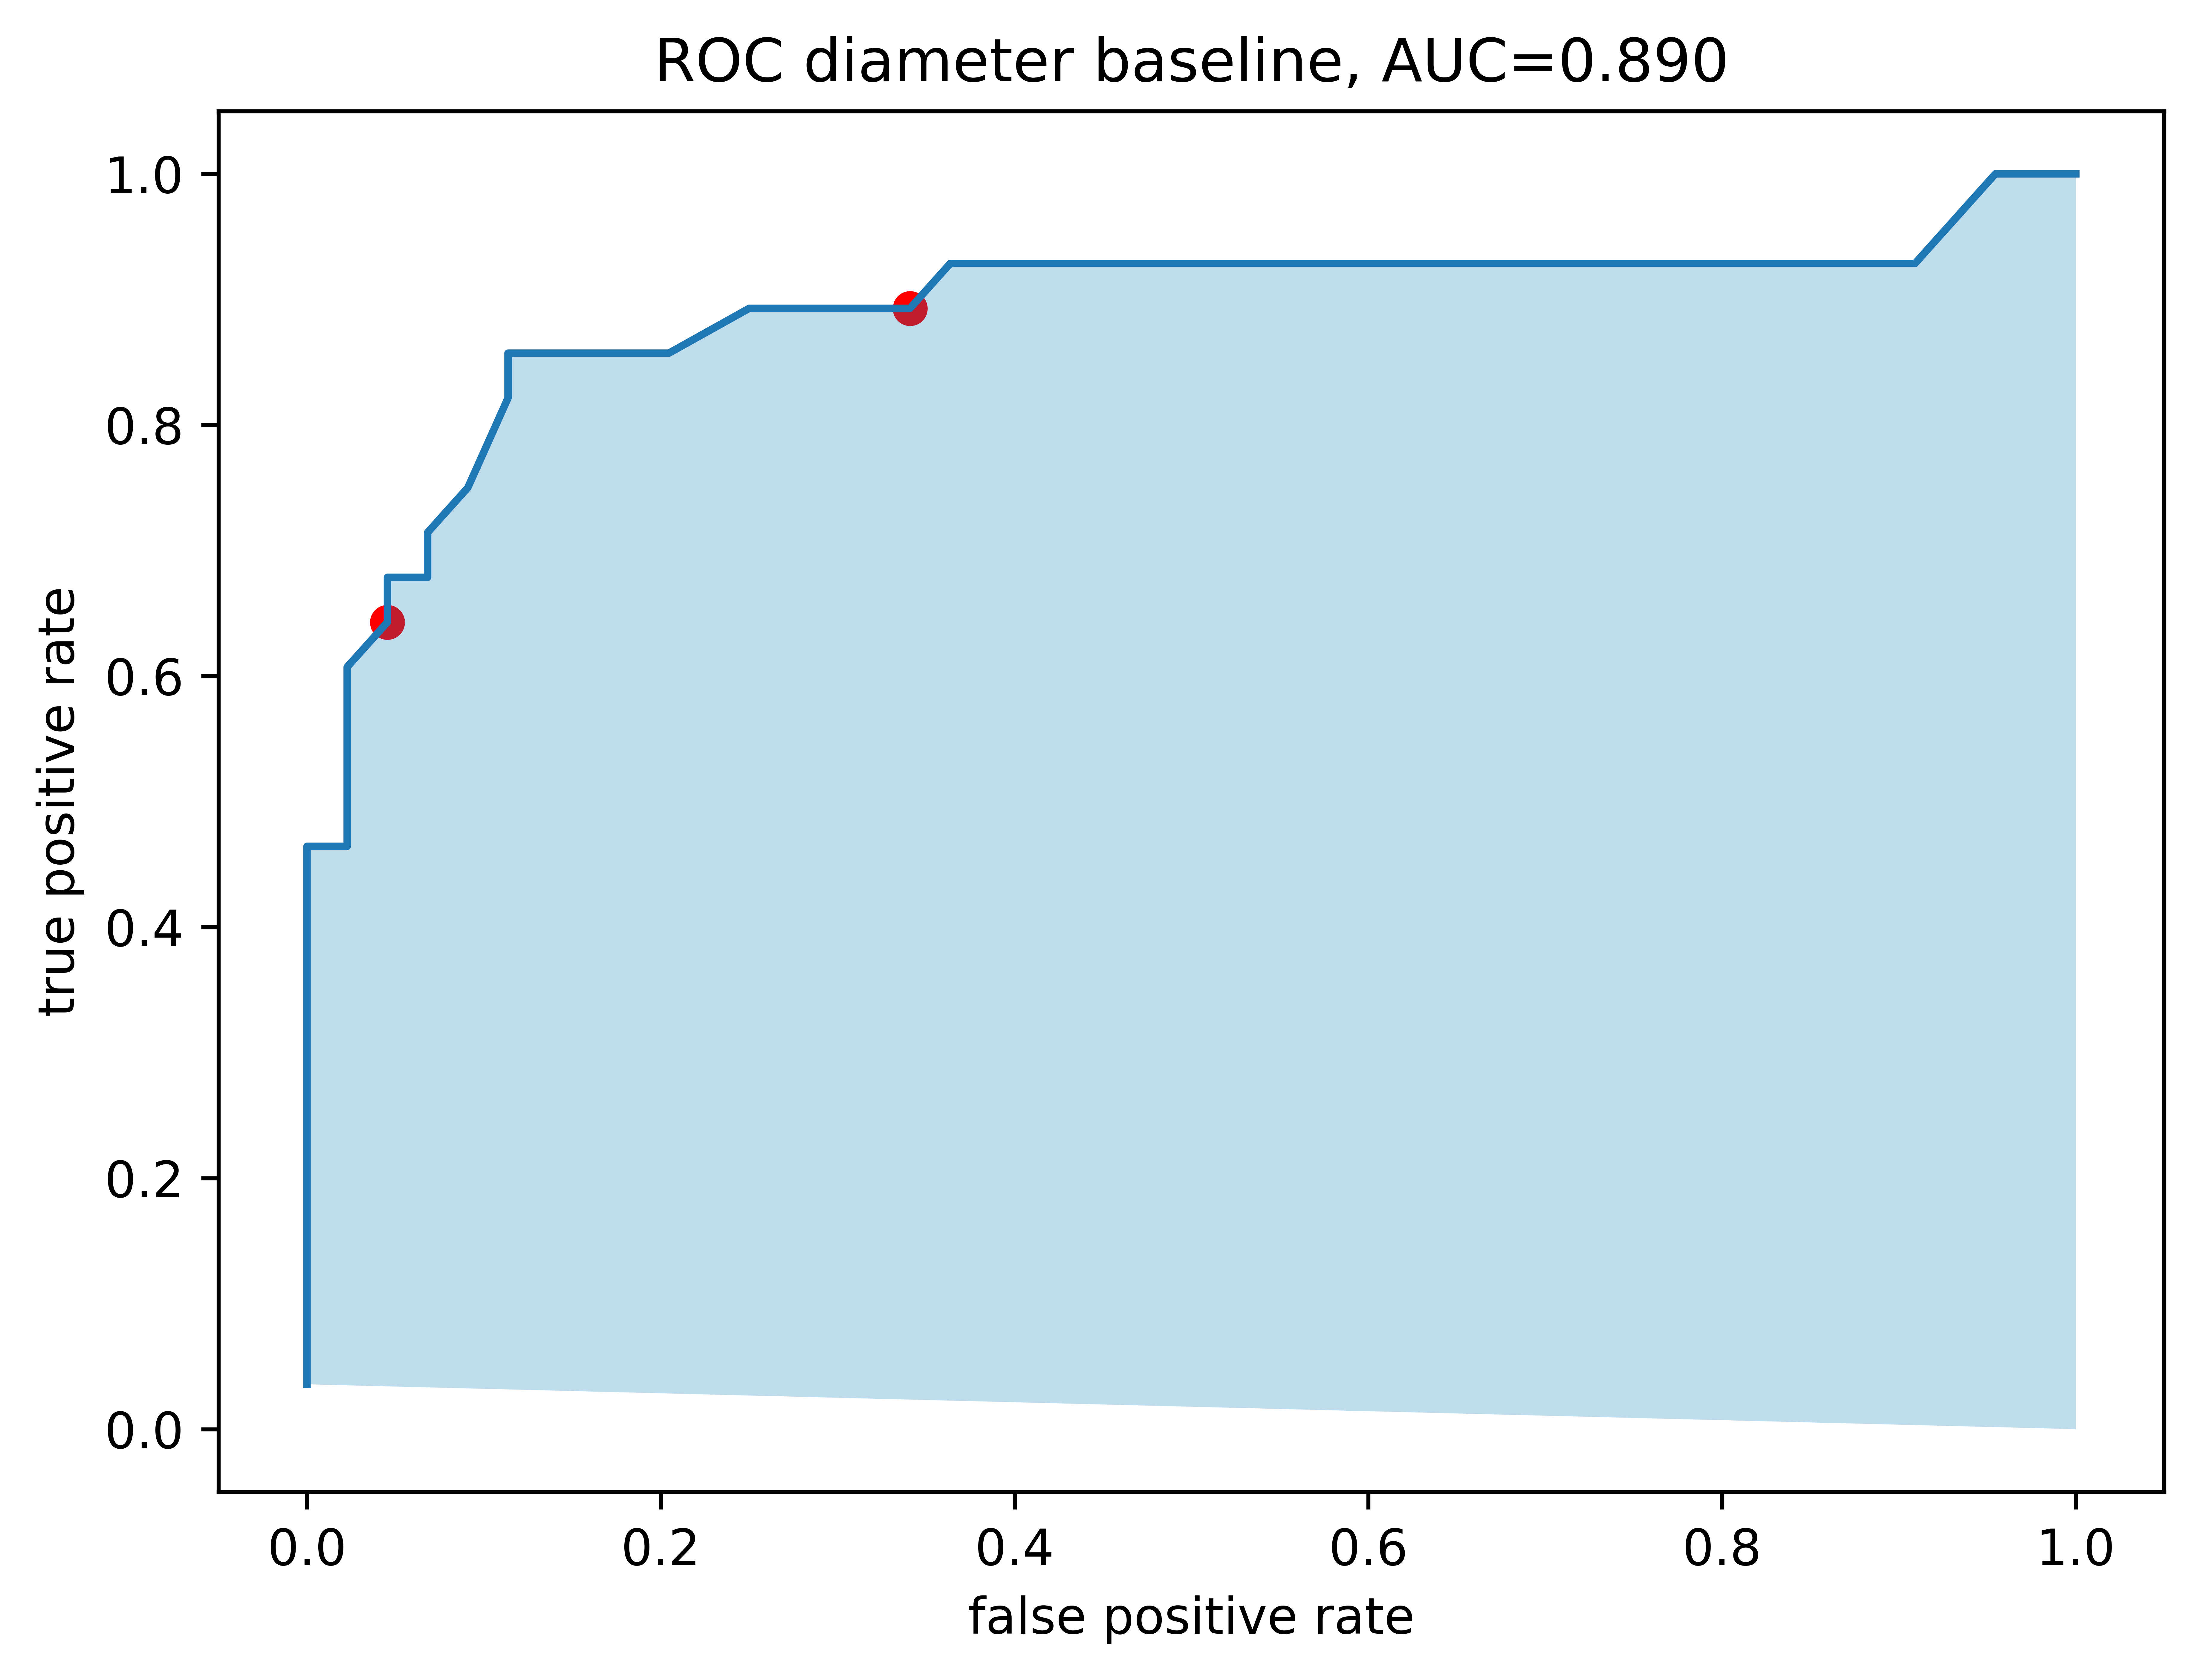

In [33]:
plt.figure(figsize=(7,5), dpi=1200)
for i in [76, 88]:
    plt.scatter(fp_diam[i], tp_diam[i], color='red')
    print(f'diam: {round(threshold[i].item(), 2)}, x: {round(fp_diam[i].item(), 2)}, y: {round(tp_diam[i].item(), 2)}')
plt.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
plt.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
plt.title(f'ROC diameter baseline, AUC={auc_diam:.3f}')
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.savefig('roc_diameter_baseline.png')

# Training

In [85]:
import argparse
import os
import shutil
import hashlib

import scipy.ndimage.measurements as measurements
import scipy.ndimage.morphology as morphology

from torch.utils.tensorboard import SummaryWriter

log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

# Used for computeBatchLoss and logMetrics to index into metrics_t/metrics_a
METRICS_LABEL_NDX=0
METRICS_PRED_NDX=1
METRICS_PRED_P_NDX=2
METRICS_LOSS_NDX=3
METRICS_SIZE = 4

In [98]:
class ClassificationTrainingApp:
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:]

        parser = argparse.ArgumentParser()
        parser.add_argument('--batch-size',
            help='Batch size to use for training',
            default=24,
            type=int,
        )
        parser.add_argument('--num-workers',
            help='Number of worker processes for background data loading',
            default=4,
            type=int,
        )
        parser.add_argument('--epochs',
            help='Number of epochs to train for',
            default=1,
            type=int,
        )
        parser.add_argument('--dataset',
            help="What to dataset to feed the model.",
            action='store',
            default='LunaDataset',
        )
        parser.add_argument('--model',
            help="What to model class name to use.",
            action='store',
            default='LunaModel',
        )
        parser.add_argument('--malignant',
            help="Train the model to classify nodules as benign or malignant.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--finetune',
            help="Start finetuning from this model.",
            default='',
        )
        parser.add_argument('--finetune-depth',
            help="Number of blocks (counted from the head) to include in finetuning",
            type=int,
            default=1,
        )
        parser.add_argument('--tb-prefix',
            default='mal',
            help="Data prefix to use for Tensorboard run. Defaults to chapter.",
        )
        parser.add_argument('comment',
            help="Comment suffix for Tensorboard run.",
            nargs='?',
            default='dlwpt',
        )

        self.cli_args = parser.parse_args(sys_argv)
        self.time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

        self.trn_writer = None
        self.val_writer = None
        self.totalTrainingSamples_count = 0

        self.augmentation_dict = {}
        if True:
        # if self.cli_args.augmented or self.cli_args.augment_flip:
            self.augmentation_dict['flip'] = True
        # if self.cli_args.augmented or self.cli_args.augment_offset:
            self.augmentation_dict['offset'] = 0.1
        # if self.cli_args.augmented or self.cli_args.augment_scale:
            self.augmentation_dict['scale'] = 0.2
        # if self.cli_args.augmented or self.cli_args.augment_rotate:
            self.augmentation_dict['rotate'] = True
        # if self.cli_args.augmented or self.cli_args.augment_noise:
            self.augmentation_dict['noise'] = 25.0

        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")

        self.model = self.initModel()
        self.optimizer = self.initOptimizer()


    def initModel(self):
#         model_cls = getattr(p2ch14.model, self.cli_args.model)
        model = LunaModel()

        if self.cli_args.finetune:
            d = torch.load(self.cli_args.finetune, map_location='cpu')
            model_blocks = [
                n for n, subm in model.named_children()
                if len(list(subm.parameters())) > 0
            ]
            finetune_blocks = model_blocks[-self.cli_args.finetune_depth:]
            log.info(f"finetuning from {self.cli_args.finetune}, blocks {' '.join(finetune_blocks)}")
            model.load_state_dict(
                {
                    k: v for k,v in d['model_state'].items()
                    if k.split('.')[0] not in model_blocks[-1]
                },
                strict=False,
            )
            for n, p in model.named_parameters():
                if n.split('.')[0] not in finetune_blocks:
                    p.requires_grad_(False)
        if self.use_cuda:
            log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
            model = model.to(self.device)
        return model

    def initOptimizer(self):
        lr = 0.003 if self.cli_args.finetune else 0.001
        return SGD(self.model.parameters(), lr=lr, weight_decay=1e-4)
        #return Adam(self.model.parameters(), lr=3e-4)

    def initTrainDl(self):
#         ds_cls = getattr(p2ch14.dsets, self.cli_args.dataset)

        train_ds = MalignantLunaDataset(
            val_stride=10,
            isValSet_bool=False,
            ratio_int=1,
        )

        batch_size = self.cli_args.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()

        train_dl = DataLoader(
            train_ds,
            batch_size=batch_size,
            num_workers=self.cli_args.num_workers,
            pin_memory=self.use_cuda,
        )

        return train_dl

    def initValDl(self):
#         ds_cls = getattr(p2ch14.dsets, self.cli_args.dataset)

        val_ds = MalignantLunaDataset(
            val_stride=10,
            isValSet_bool=True,
        )

        batch_size = self.cli_args.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()

        val_dl = DataLoader(
            val_ds,
            batch_size=batch_size,
            num_workers=self.cli_args.num_workers,
            pin_memory=self.use_cuda,
        )

        return val_dl

    def initTensorboardWriters(self):
        if self.trn_writer is None:
            log_dir = os.path.join('runs', self.cli_args.tb_prefix,
                                   self.time_str)

            self.trn_writer = SummaryWriter(
                log_dir=log_dir + '-trn_cls-' + self.cli_args.comment)
            self.val_writer = SummaryWriter(
                log_dir=log_dir + '-val_cls-' + self.cli_args.comment)


    def main(self):
        log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))

        train_dl = self.initTrainDl()
        val_dl = self.initValDl()

        best_score = 0.0
        validation_cadence = 5 if not self.cli_args.finetune else 1
        for epoch_ndx in range(1, self.cli_args.epochs + 1):

            log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
                epoch_ndx,
                self.cli_args.epochs,
                len(train_dl),
                len(val_dl),
                self.cli_args.batch_size,
                (torch.cuda.device_count() if self.use_cuda else 1),
            ))

            trnMetrics_t = self.doTraining(epoch_ndx, train_dl)
            self.logMetrics(epoch_ndx, 'trn', trnMetrics_t)

            if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
                valMetrics_t = self.doValidation(epoch_ndx, val_dl)
                score = self.logMetrics(epoch_ndx, 'val', valMetrics_t)
                best_score = max(score, best_score)

                # TODO: this 'cls' will need to change for the malignant classifier
                self.saveModel('cls', epoch_ndx, score == best_score)


        if hasattr(self, 'trn_writer'):
            self.trn_writer.close()
            self.val_writer.close()


    def doTraining(self, epoch_ndx, train_dl):
        self.model.train()
        train_dl.dataset.shuffleSamples()
        trnMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(train_dl.dataset),
            device=self.device,
        )

        batch_iter = enumerateWithEstimate(
            train_dl,
            "E{} Training".format(epoch_ndx),
            start_ndx=train_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            self.optimizer.zero_grad()

            loss_var = self.computeBatchLoss(
                batch_ndx,
                batch_tup,
                train_dl.batch_size,
                trnMetrics_g,
                augment=True
            )

            loss_var.backward()
            self.optimizer.step()

        self.totalTrainingSamples_count += len(train_dl.dataset)

        return trnMetrics_g.to('cpu')


    def doValidation(self, epoch_ndx, val_dl):
        with torch.no_grad():
            self.model.eval()
            valMetrics_g = torch.zeros(
                METRICS_SIZE,
                len(val_dl.dataset),
                device=self.device,
            )

            batch_iter = enumerateWithEstimate(
                val_dl,
                "E{} Validation ".format(epoch_ndx),
                start_ndx=val_dl.num_workers,
            )
            for batch_ndx, batch_tup in batch_iter:
                self.computeBatchLoss(
                    batch_ndx,
                    batch_tup,
                    val_dl.batch_size,
                    valMetrics_g,
                    augment=False
                )

        return valMetrics_g.to('cpu')



    def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g,
                         augment=True):
        input_t, label_t, index_t, _series_list, _center_list = batch_tup

        input_g = input_t.to(self.device, non_blocking=True)
        label_g = label_t.to(self.device, non_blocking=True)
        index_g = index_t.to(self.device, non_blocking=True)


        if augment:
            input_g = augment3d(input_g)

        logits_g, probability_g = self.model(input_g)

        loss_g = nn.functional.cross_entropy(logits_g, label_g[:, 1],
                                             reduction="none")
        start_ndx = batch_ndx * batch_size
        end_ndx = start_ndx + label_t.size(0)

        _, predLabel_g = torch.max(probability_g, dim=1, keepdim=False,
                                   out=None)

        # log.debug(index_g)

        metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = index_g
        metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = predLabel_g
        # metrics_g[METRICS_PRED_N_NDX, start_ndx:end_ndx] = probability_g[:,0]
        metrics_g[METRICS_PRED_P_NDX, start_ndx:end_ndx] = probability_g[:,1]
        # metrics_g[METRICS_PRED_M_NDX, start_ndx:end_ndx] = probability_g[:,2]
        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = loss_g

        return loss_g.mean()


    def logMetrics(
            self,
            epoch_ndx,
            mode_str,
            metrics_t,
            classificationThreshold=0.5,
    ):
        self.initTensorboardWriters()
        log.info("E{} {}".format(
            epoch_ndx,
            type(self).__name__,
        ))

        if self.cli_args.dataset == 'MalignantLunaDataset':
            pos = 'mal'
            neg = 'ben'
        else:
            pos = 'pos'
            neg = 'neg'


        negLabel_mask = metrics_t[METRICS_LABEL_NDX] == 0
        negPred_mask = metrics_t[METRICS_PRED_NDX] == 0

        posLabel_mask = ~negLabel_mask
        posPred_mask = ~negPred_mask

        # benLabel_mask = metrics_t[METRICS_LABEL_NDX] == 1
        # benPred_mask = metrics_t[METRICS_PRED_NDX] == 1
        #
        # malLabel_mask = metrics_t[METRICS_LABEL_NDX] == 2
        # malPred_mask = metrics_t[METRICS_PRED_NDX] == 2

        # benLabel_mask = ~malLabel_mask & posLabel_mask
        # benPred_mask = ~malPred_mask & posLabel_mask

        neg_count = int(negLabel_mask.sum())
        pos_count = int(posLabel_mask.sum())
        # ben_count = int(benLabel_mask.sum())
        # mal_count = int(malLabel_mask.sum())

        neg_correct = int((negLabel_mask & negPred_mask).sum())
        pos_correct = int((posLabel_mask & posPred_mask).sum())
        # ben_correct = int((benLabel_mask & benPred_mask).sum())
        # mal_correct = int((malLabel_mask & malPred_mask).sum())

        trueNeg_count = neg_correct
        truePos_count = pos_correct

        falsePos_count = neg_count - neg_correct
        falseNeg_count = pos_count - pos_correct

        metrics_dict = {}
        metrics_dict['loss/all'] = metrics_t[METRICS_LOSS_NDX].mean()
        metrics_dict['loss/neg'] = metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean()
        metrics_dict['loss/pos'] = metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean()
        # metrics_dict['loss/ben'] = metrics_t[METRICS_LOSS_NDX, benLabel_mask].mean()
        # metrics_dict['loss/mal'] = metrics_t[METRICS_LOSS_NDX, malLabel_mask].mean()

        metrics_dict['correct/all'] = (pos_correct + neg_correct) / metrics_t.shape[1] * 100
        metrics_dict['correct/neg'] = (neg_correct) / neg_count * 100
        metrics_dict['correct/pos'] = (pos_correct) / pos_count * 100
        # metrics_dict['correct/ben'] = (ben_correct) / ben_count * 100
        # metrics_dict['correct/mal'] = (mal_correct) / mal_count * 100

        precision = metrics_dict['pr/precision'] = \
            truePos_count / np.float64(truePos_count + falsePos_count)
        recall    = metrics_dict['pr/recall'] = \
            truePos_count / np.float64(truePos_count + falseNeg_count)

        metrics_dict['pr/f1_score'] = \
            2 * (precision * recall) / (precision + recall)

        threshold = torch.linspace(1, 0, steps=100)
        tpr = (metrics_t[None, METRICS_PRED_P_NDX, posLabel_mask] >= threshold[:, None]).sum(1).float() / pos_count
        fpr = (metrics_t[None, METRICS_PRED_P_NDX, negLabel_mask] >= threshold[:, None]).sum(1).float() / neg_count
        fp_diff = fpr[1:]-fpr[:-1]
        tp_avg  = (tpr[1:]+tpr[:-1])/2
        auc = (fp_diff * tp_avg).sum()
        metrics_dict['auc'] = auc

        log.info(
            ("E{} {:8} {loss/all:.4f} loss, "
                 + "{correct/all:-5.1f}% correct, "
                 + "{pr/precision:.4f} precision, "
                 + "{pr/recall:.4f} recall, "
                 + "{pr/f1_score:.4f} f1 score, "
                 + "{auc:.4f} auc"
            ).format(
                epoch_ndx,
                mode_str,
                **metrics_dict,
            )
        )
        log.info(
            ("E{} {:8} {loss/neg:.4f} loss, "
                 + "{correct/neg:-5.1f}% correct ({neg_correct:} of {neg_count:})"
            ).format(
                epoch_ndx,
                mode_str + '_' + neg,
                neg_correct=neg_correct,
                neg_count=neg_count,
                **metrics_dict,
            )
        )
        log.info(
            ("E{} {:8} {loss/pos:.4f} loss, "
                 + "{correct/pos:-5.1f}% correct ({pos_correct:} of {pos_count:})"
            ).format(
                epoch_ndx,
                mode_str + '_' + pos,
                pos_correct=pos_correct,
                pos_count=pos_count,
                **metrics_dict,
            )
        )
        # log.info(
        #     ("E{} {:8} {loss/ben:.4f} loss, "
        #          + "{correct/ben:-5.1f}% correct ({ben_correct:} of {ben_count:})"
        #     ).format(
        #         epoch_ndx,
        #         mode_str + '_ben',
        #         ben_correct=ben_correct,
        #         ben_count=ben_count,
        #         **metrics_dict,
        #     )
        # )
        # log.info(
        #     ("E{} {:8} {loss/mal:.4f} loss, "
        #          + "{correct/mal:-5.1f}% correct ({mal_correct:} of {mal_count:})"
        #     ).format(
        #         epoch_ndx,
        #         mode_str + '_mal',
        #         mal_correct=mal_correct,
        #         mal_count=mal_count,
        #         **metrics_dict,
        #     )
        # )
        writer = getattr(self, mode_str + '_writer')

        for key, value in metrics_dict.items():
            key = key.replace('pos', pos)
            key = key.replace('neg', neg)
            writer.add_scalar(key, value, self.totalTrainingSamples_count)

        fig = plt.figure()
        plt.plot(fpr, tpr)
        writer.add_figure('roc', fig, self.totalTrainingSamples_count)

        writer.add_scalar('auc', auc, self.totalTrainingSamples_count)
# # tag::logMetrics_writer_prcurve[]
#        writer.add_pr_curve(
#            'pr',
#            metrics_t[METRICS_LABEL_NDX],
#            metrics_t[METRICS_PRED_P_NDX],
#            self.totalTrainingSamples_count,
#        )
# # end::logMetrics_writer_prcurve[]

        bins = np.linspace(0, 1)

        writer.add_histogram(
            'label_neg',
            metrics_t[METRICS_PRED_P_NDX, negLabel_mask],
            self.totalTrainingSamples_count,
            bins=bins
        )
        writer.add_histogram(
            'label_pos',
            metrics_t[METRICS_PRED_P_NDX, posLabel_mask],
            self.totalTrainingSamples_count,
            bins=bins
        )

        if not self.cli_args.malignant:
            score = metrics_dict['pr/f1_score']
        else:
            score = metrics_dict['auc']

        return score

    def saveModel(self, type_str, epoch_ndx, isBest=False):
        file_path = os.path.join(
            'models',
            self.cli_args.tb_prefix,
            '{}_{}_{}.{}.state'.format(
                type_str,
                self.time_str,
                self.cli_args.comment,
                self.totalTrainingSamples_count,
            )
        )

        os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

        model = self.model
        if isinstance(model, torch.nn.DataParallel):
            model = model.module

        state = {
            'model_state': model.state_dict(),
            'model_name': type(model).__name__,
            'optimizer_state' : self.optimizer.state_dict(),
            'optimizer_name': type(self.optimizer).__name__,
            'epoch': epoch_ndx,
            'totalTrainingSamples_count': self.totalTrainingSamples_count,
        }
        torch.save(state, file_path)

        log.debug("Saved model params to {}".format(file_path))

        if isBest:
            best_path = os.path.join(
                'models',
                self.cli_args.tb_prefix,
                '{}_{}_{}.{}.state'.format(
                    type_str,
                    self.time_str,
                    self.cli_args.comment,
                    'best',
                )
            )
            shutil.copyfile(file_path, best_path)

            log.debug("Saved model params to {}".format(best_path))

        with open(file_path, 'rb') as f:
            log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

# Prepare Catch

In [99]:
class LunaPrepCacheApp:
    @classmethod
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:]

    def main(self):
        log.info("Starting {}".format(type(self).__name__))

        self.prep_dl = DataLoader(
            LunaDataset(
                sortby_str='series_uid',
            ),
            batch_size=1024,
            num_workers=4,
        )

        batch_iter = enumerateWithEstimate(
            self.prep_dl,
            "Stuffing cache",
            start_ndx=4,
        )
        for batch_ndx, batch_tup in batch_iter:
            pass
        
        for _ in batch_iter:
            pass

In [66]:
pre = LunaPrepCacheApp()

In [67]:
pre.main()

2024-07-06 05:29:33,561 INFO     pid:34 __main__:027:main Starting LunaPrepCacheApp
2024-07-06 05:29:33,590 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7cedad3ff5b0>: 5084 validation samples, 5008 neg, 76 pos, unbalanced ratio
2024-07-06 05:29:33,592 WARNING  pid:34 __main__:081:enumerateWithEstimate Stuffing cache ----/5, starting
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
2024-07-06 05:29:43,775 WARNING  pid:34 __main__:111:enumerateWithEstimate Stuffing cache ----/5, done at 2024-07-06 05:29:43


# Start Training

### Train 1 (epoch=10, depth=1)

In [100]:
app = ClassificationTrainingApp(['--malignant', 
                                 '--epochs', '10',
                                 '--dataset', 'MalignantLunaDataset',
                                 '--finetune', '/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state'
                                ])

2024-07-06 05:47:33,774 INFO     pid:34 __main__:094:initModel finetuning from /kaggle/input/seg-cls-model/Nodule_Detect_model_last.state, blocks head_linear
2024-07-06 05:47:33,776 INFO     pid:34 __main__:106:initModel Using CUDA; 2 devices.


In [101]:
app.device

device(type='cuda')

In [102]:
app.main()

2024-07-06 05:47:35,233 INFO     pid:34 __main__:172:main Starting ClassificationTrainingApp, Namespace(batch_size=24, num_workers=4, epochs=10, dataset='MalignantLunaDataset', model='LunaModel', malignant=True, finetune='/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state', finetune_depth=1, tb_prefix='mal', comment='dlwpt')
2024-07-06 05:47:35,306 INFO     pid:34 __main__:055:__init__ <__main__.MalignantLunaDataset object at 0x7ceee8d08e80>: 44916 training samples, 44272 neg, 644 pos, 1:1 ratio
2024-07-06 05:47:35,324 INFO     pid:34 __main__:055:__init__ <__main__.MalignantLunaDataset object at 0x7ceced30e1a0>: 5084 validation samples, 5008 neg, 76 pos, unbalanced ratio
2024-07-06 05:47:35,325 INFO     pid:34 __main__:181:main Epoch 1 of 10, 2084/2 batches of size 24*2
2024-07-06 05:47:35,399 WARNING  pid:34 __main__:081:enumerateWithEstimate E1 Training ----/2084, starting
2024-07-06 05:47:36,481 INFO     pid:34 __main__:098:enumerateWithEstimate E1 Training   16/2084, done 

### Train 2 (epoch=10, depth=2)

In [103]:
app2 = ClassificationTrainingApp(['--malignant', 
                                  '--epochs', '10',
                                  '--dataset', 'MalignantLunaDataset',
                                  '--finetune', '/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state',
                                  '--finetune-depth', '2',
                                ])

2024-07-06 06:02:57,175 INFO     pid:34 __main__:094:initModel finetuning from /kaggle/input/seg-cls-model/Nodule_Detect_model_last.state, blocks block4 head_linear
2024-07-06 06:02:57,178 INFO     pid:34 __main__:106:initModel Using CUDA; 2 devices.


In [104]:
app2.device

device(type='cuda')

In [105]:
app2.main()

2024-07-06 06:03:43,135 INFO     pid:34 __main__:172:main Starting ClassificationTrainingApp, Namespace(batch_size=24, num_workers=4, epochs=10, dataset='MalignantLunaDataset', model='LunaModel', malignant=True, finetune='/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state', finetune_depth=2, tb_prefix='mal', comment='dlwpt')
2024-07-06 06:03:43,214 INFO     pid:34 __main__:055:__init__ <__main__.MalignantLunaDataset object at 0x7cecda239690>: 44916 training samples, 44272 neg, 644 pos, 1:1 ratio
2024-07-06 06:03:43,237 INFO     pid:34 __main__:055:__init__ <__main__.MalignantLunaDataset object at 0x7cecda2099c0>: 5084 validation samples, 5008 neg, 76 pos, unbalanced ratio
2024-07-06 06:03:43,238 INFO     pid:34 __main__:181:main Epoch 1 of 10, 2084/2 batches of size 24*2
2024-07-06 06:03:43,320 WARNING  pid:34 __main__:081:enumerateWithEstimate E1 Training ----/2084, starting
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fo

In [106]:
!zip -r run_mal.zip /kaggle/working/runs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/mal/ (stored 0%)
  adding: kaggle/working/runs/mal/2024-07-06_05.29.54-trn_cls-dlwpt/ (stored 0%)
  adding: kaggle/working/runs/mal/2024-07-06_05.29.54-trn_cls-dlwpt/events.out.tfevents.1720243879.dd84db7ce9f7.34.0 (deflated 9%)
  adding: kaggle/working/runs/mal/2024-07-06_05.34.34-val_cls-dlwpt/ (stored 0%)
  adding: kaggle/working/runs/mal/2024-07-06_05.34.34-val_cls-dlwpt/events.out.tfevents.1720244147.dd84db7ce9f7.34.5 (deflated 9%)
  adding: kaggle/working/runs/mal/2024-07-06_06.02.57-trn_cls-dlwpt/ (stored 0%)
  adding: kaggle/working/runs/mal/2024-07-06_06.02.57-trn_cls-dlwpt/events.out.tfevents.1720245893.dd84db7ce9f7.34.14 (deflated 24%)
  adding: kaggle/working/runs/mal/2024-07-06_05.43.43-trn_cls-dlwpt/ (stored 0%)
  adding: kaggle/working/runs/mal/2024-07-06_05.43.43-trn_cls-dlwpt/events.out.tfevents.1720244698.dd84db7ce9f7.34.10 (deflated 15%)
  adding: kaggle/working/runs/mal/2024-07-06_05.32.31-trn_

In [107]:
!zip -r model_mal.zip /kaggle/working/models

  adding: kaggle/working/models/ (stored 0%)
  adding: kaggle/working/models/mal/ (stored 0%)
  adding: kaggle/working/models/mal/cls_2024-07-06_05.47.33_dlwpt.800000.state (deflated 8%)
  adding: kaggle/working/models/mal/cls_2024-07-06_05.47.33_dlwpt.1000000.state (deflated 8%)
  adding: kaggle/working/models/mal/cls_2024-07-06_06.02.57_dlwpt.500000.state (deflated 8%)
  adding: kaggle/working/models/mal/cls_2024-07-06_06.02.57_dlwpt.200000.state (deflated 8%)
  adding: kaggle/working/models/mal/cls_2024-07-06_06.02.57_dlwpt.300000.state (deflated 8%)
  adding: kaggle/working/models/mal/cls_2024-07-06_05.47.33_dlwpt.100000.state (deflated 8%)
  adding: kaggle/working/models/mal/cls_2024-07-06_05.47.33_dlwpt.600000.state (deflated 8%)
  adding: kaggle/working/models/mal/cls_2024-07-06_06.02.57_dlwpt.400000.state (deflated 8%)
  adding: kaggle/working/models/mal/cls_2024-07-06_05.47.33_dlwpt.300000.state (deflated 8%)
  adding: kaggle/working/models/mal/cls_2024-07-06_05.47.33_dlwpt.be

# Analyze after training model

In [35]:
model1 = LunaModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sd = torch.load('/kaggle/input/mal-model/cls_2024-07-06_05.47.33_dlwpt.dep_1.1000000.state', map_location=torch.device('cpu'))
model1.load_state_dict(sd['model_state'])
model1.to(device)
model1.eval()

LunaModel(
  (tail_batchnorm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): LunaBlock(
    (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): LunaBlock(
    (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): LunaBlock(
    (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(32, 32, kernel_siz

In [36]:
ds = MalignantLunaDataset(val_stride=10, isValSet_bool=True)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=4)

2024-07-06 08:50:35,720 INFO     pid:33 __main__:055:__init__ <__main__.MalignantLunaDataset object at 0x78bea3c7df00>: 30136 validation samples, 30064 neg, 72 pos, unbalanced ratio


In [37]:
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)    
    truth += (label[:,1]>0).tolist()
    with torch.no_grad():
        _, p = model1(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

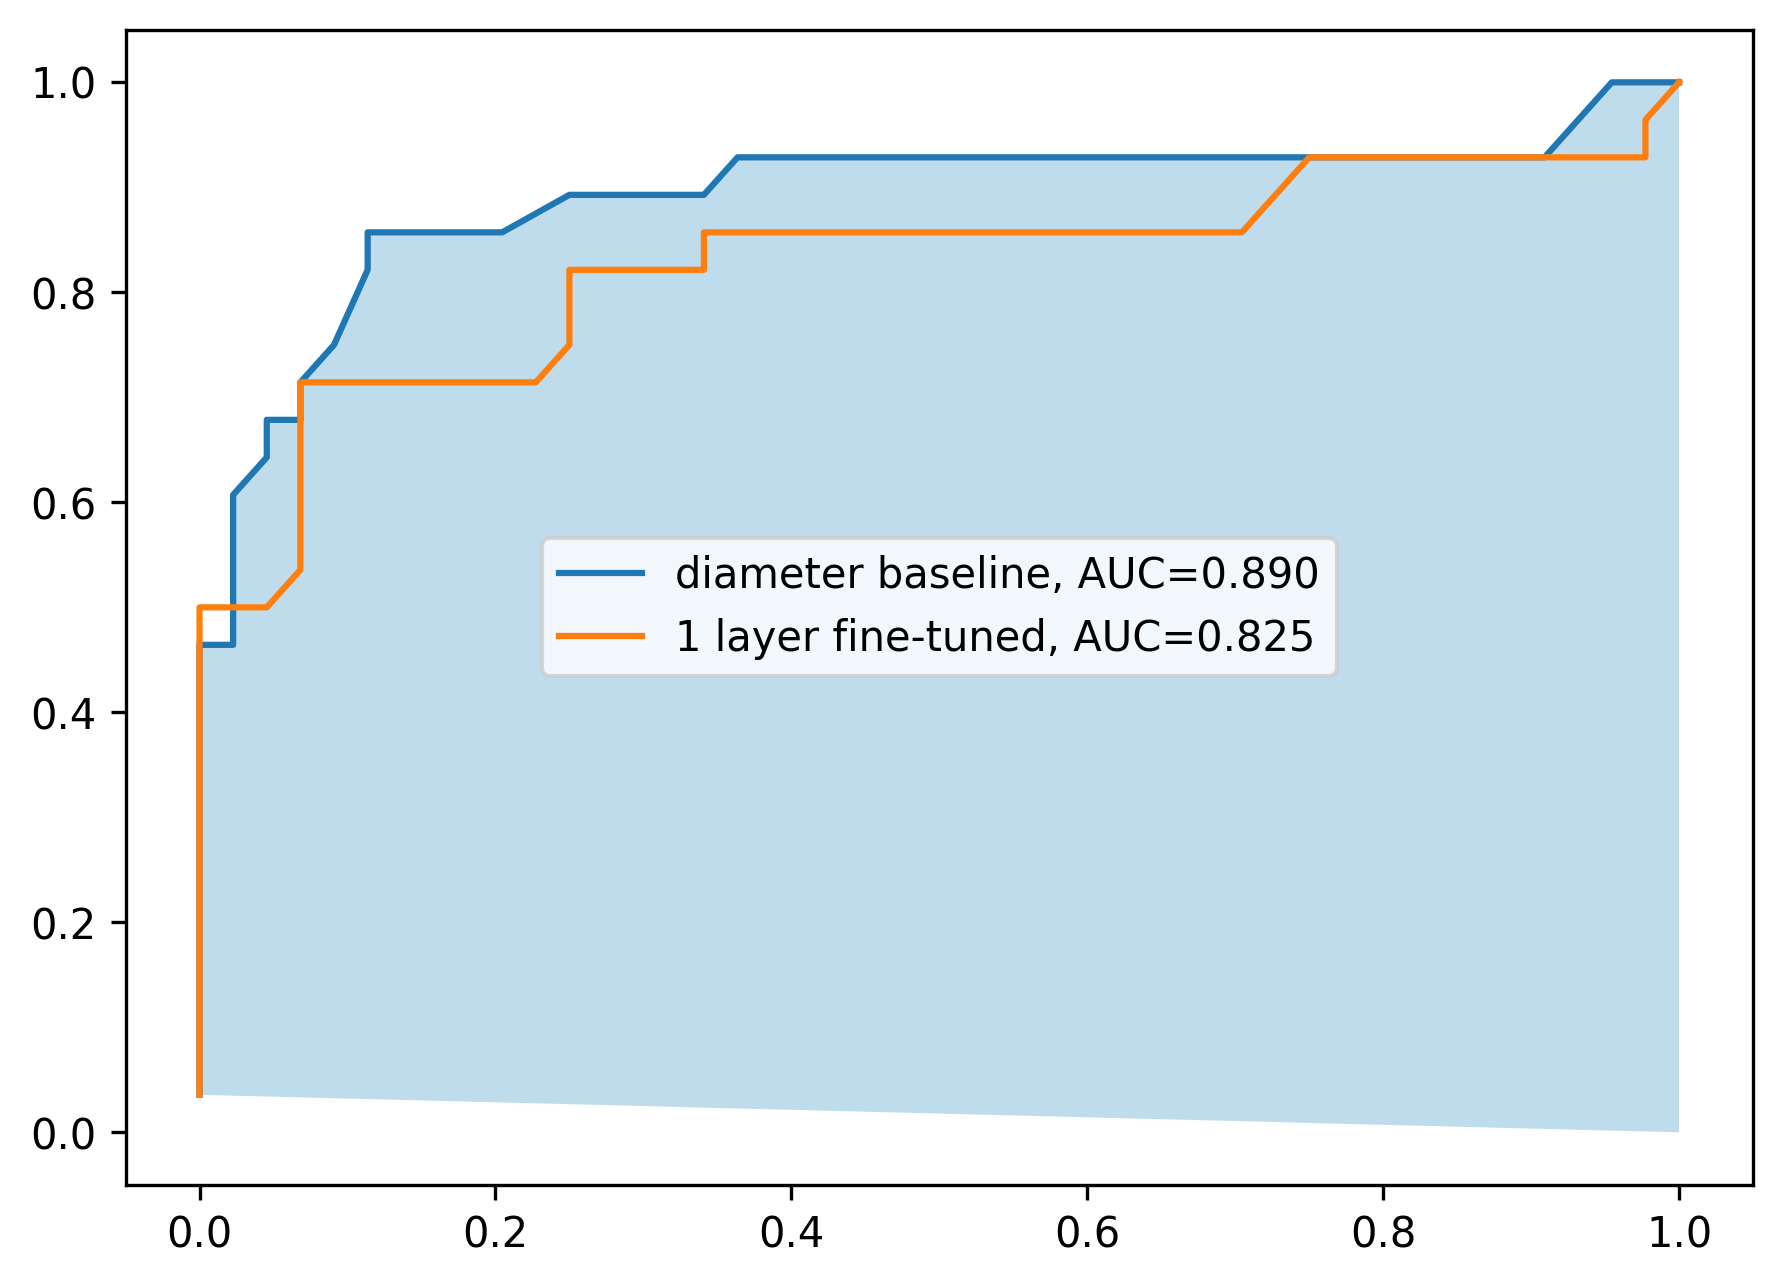

In [38]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0, steps=100)
tp_finetune = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp_finetune = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben
fp_finetune_diff = fp_finetune[1:]-fp_finetune[:-1]
tp_finetune_avg  = (tp_finetune[1:]+tp_finetune[:-1])/2
auc_finetune = (fp_finetune_diff * tp_finetune_avg).sum()

plt.figure(figsize=(7,5), dpi=300)
plt.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
plt.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
plt.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
plt.legend()
plt.savefig('roc_finetune.png')

In [41]:
model2 = LunaModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sd = torch.load('/kaggle/input/mal-model/cls_2024-07-06_06.02.57_dlwpt.dep_2.1000000.state', map_location=torch.device('cpu'))
model2.load_state_dict(sd['model_state'])
model2.to(device)
model2.eval()

LunaModel(
  (tail_batchnorm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): LunaBlock(
    (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): LunaBlock(
    (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): LunaBlock(
    (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(32, 32, kernel_siz

In [42]:
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)    
    truth += (label[:,1]>0).tolist()
    with torch.no_grad():
        _, p = model2(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

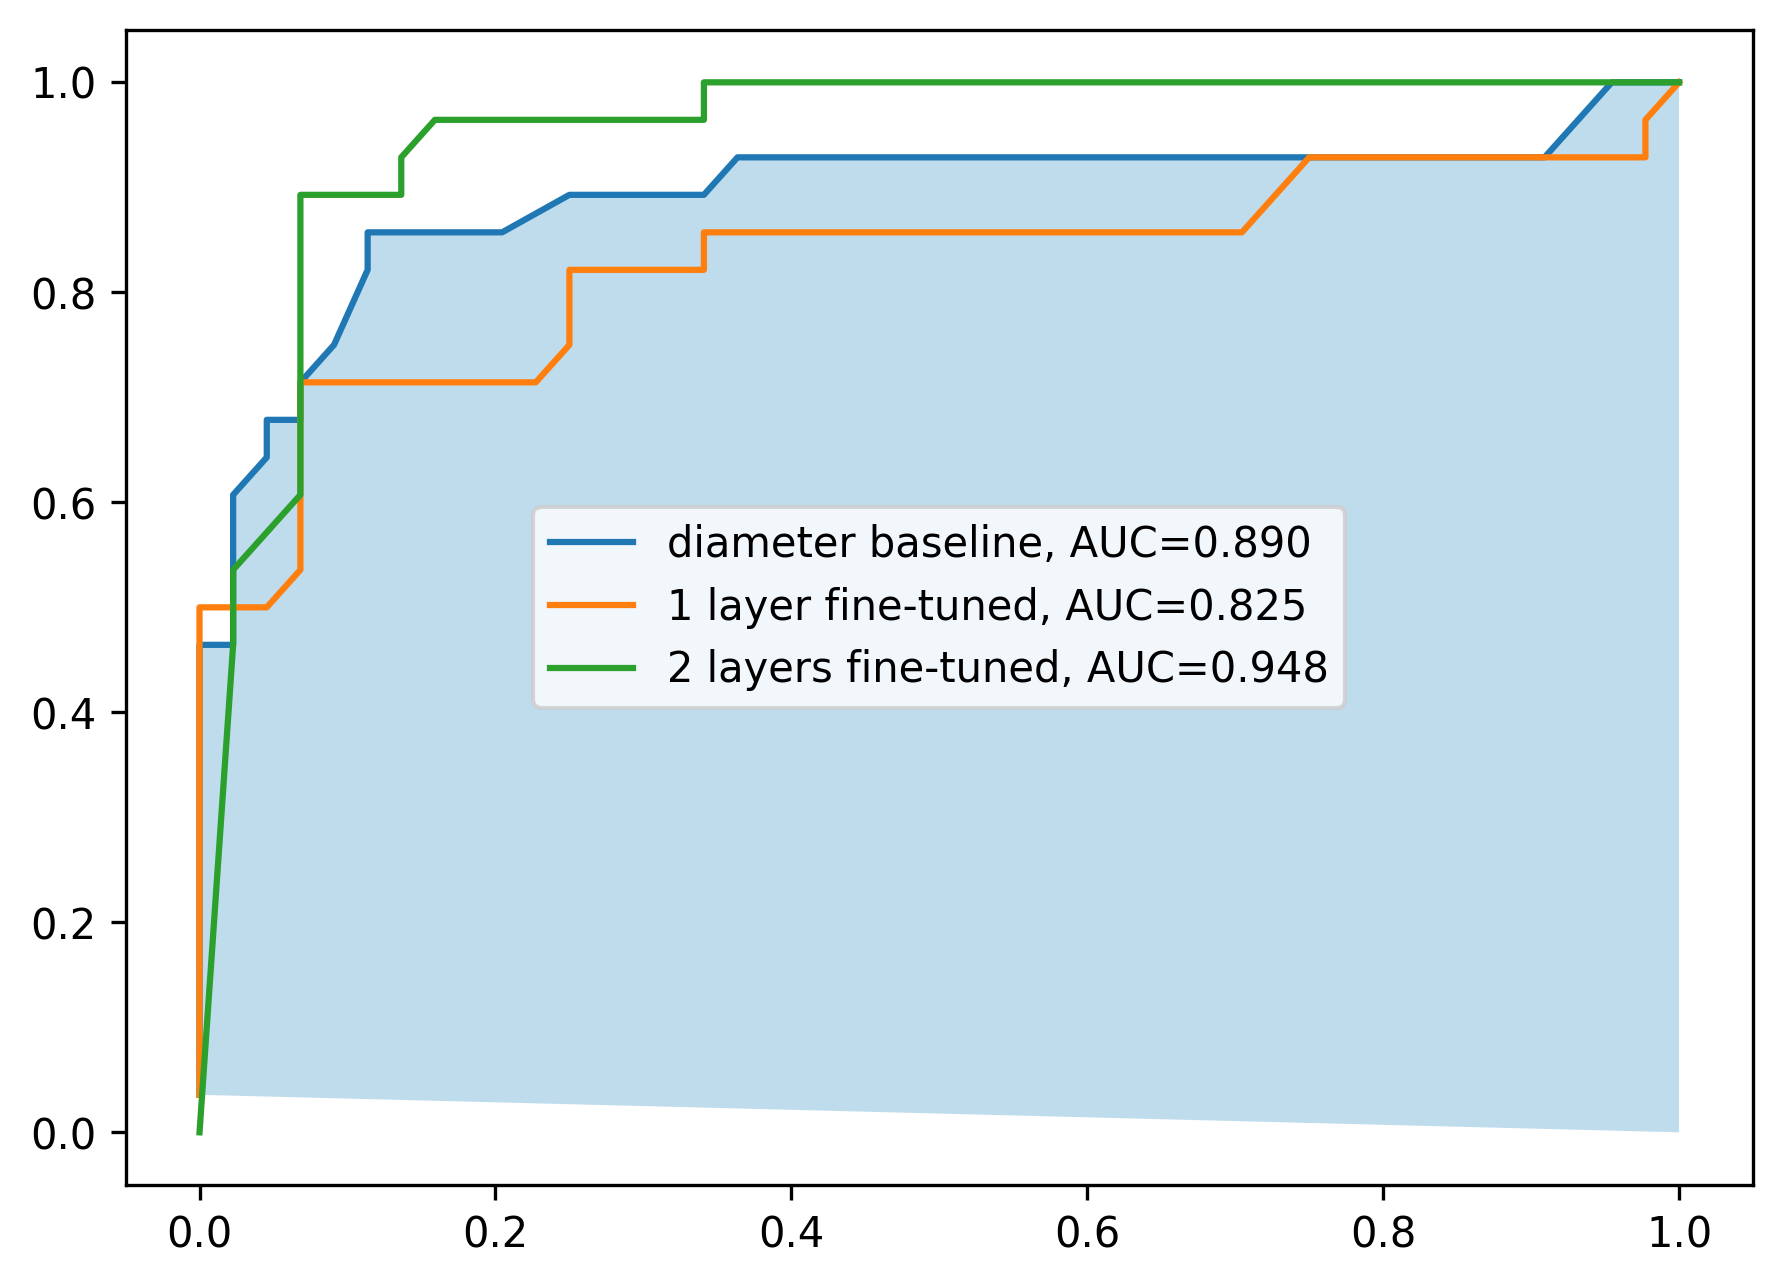

In [43]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0, steps=100)
tp = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben

fp_diff = fp[1:]-fp[:-1]
tp_avg  = (tp[1:]+tp[:-1])/2
auc_modified = (fp_diff * tp_avg).sum()

plt.figure(figsize=(7,5), dpi=300)
plt.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
plt.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
plt.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
plt.plot(fp, tp, label=f'2 layers fine-tuned, AUC={auc_modified:.3f}')
plt.legend()
plt.savefig('roc_modified.png')